## Lesson 6: Seeing the Moon
#### Learning Objectives:
After completing this lesson, users will be able to:
1. objective 1
2. objective 2
3. objective 3

_Python libraries introduced in this lesson:_ [`netcdf4`](https://unidata.github.io/netcdf4-python/), [`scipy.ndimage`](https://docs.scipy.org/doc/scipy/reference/ndimage.html)

### Introduction

The Shinnecock are a federally recognized tribe based in eastern Long Island. Like many other tribes along the eastern seaboard, colonialism caused great hardship and loss for the Shinnecock. Land is put at the center of the colonialism discussion, but land is what the colonists gained; it is only the beginning of what indigenous tribes lost. Traditional language, ceremonies, and cultural practices were outlawed; children were taken away from their families; Shinnecock men were left to die on ships in storms while products were given preference to be taken ashore first. 

For several generations, the Shinnecock have been attempting to bring back lost cultural traditions, much of which has been done by travelling to other closely related communities and re-learning our ways. One of the recently revived traditions is the *Full Moon Ceremony* in which female members of the tribe honor _Nukimis Nanapashot_ (Grandmother Moon Spirit). The women of the tribe are tied to the water, the moon, and its calendar. Each month, when the moon is full and its power strongest, this ceremony is held to allow the participants to cleanse themselves and their energy.

Today, in Western science, the Moon is considered full on one particular date in the synodic month (New Moon to New Moon). However, this strict concept of fullness is not adhered to in the ceremonies. You may have noticed that the Moon "looks full" for a few days before and after the exact date of the full Moon.

In this notebook, we will use computer vision, in particular morphological analysis, to explore the fullness of the Moon and compare this to the dates on which the ceremony is permitted to be held.

Currently, Full Moon Ceremonies are practiced within three days on either side of the full Moon. Here we will use publicly available data to quantify the illumination percentage of the Moon throughout the higher illumination periods of its cycle, and relate this to the visual appearance of the Moon during the times in which the ceremony is practiced. Subsequently we'll use this information to back-compute possible ceremony dates from the past using ephemeris information.

### Background on the Dataset

For this analysis we will need a dataset of full-disk images of the Moon in various phases. Luckily, there are plenty of satellites that use the Moon to calibrate their instruments. They contribute to the [GLOD (GSICS Lunar
Observation Dataset)](http://gsics.atmos.umd.edu/bin/view/Development/LunarWorkArea) which accumulates the lunar data taken from these satellites to create a calibration model using the Moon. Unfortunately, the GLOD is not publicly shareable. However, the data of many of the satellites that contribute to it _are_ public. We will focus on the GOES-R series (that's GOES-16, GOES-17, and GOES-18) satellites [ABI instruments](https://www.goes-r.gov/spacesegment/abi.html). The data that these instruments use for calibration with the moon contains `LUN` in the filenames and can be obtained from [NOAA CLASS GRICABI dataset](https://www.aev.class.noaa.gov/saa/products/search?sub_id=0&datatype_family=GRICABI&submit.x=18&submit.y=6).

In generating this training we downloaded the entirety of the LUN dataset for all three satellites up to that date, and ran them all through the exercise you'll be doing here. That was about 700 GB and it's unrealistic to expect you to reproduce that scale of work! Instead, we've curated a small subset of the dataset so you can learn the same techniques (without having to go through the delay of waiting for your data order through NOAA CLASS or overloading your harddrive).

We've also massaged the data to make it a bit easier to work with. These files have been downsized to only include the data relevant for this exercise (radiance). The original GOES files also contain 2 or 4 frames within the same array. We have dissected and separated these arrays so each file represents only one frame. This merged frame style is something we only find in the calibration data, so if you work with GOES atmospheric data this isn't a step you'd need to consider. For a deeper dive into the preprocessing steps that were performed and how we chose the files to include in this subset you can check out the functions we used (which have docstrings with detailed descriptions) [here](https://gist.github.com/Sierra-MC/4aa3eb54ec3ce4ebeafac44468b61a1a).

You can download the data subset here: https://kts-dev-data.s3.amazonaws.com/goes/goes_subset_flat.tar.gz

You'll need to decompress ("ungzip" and "untar") the subset in order to use the data. Head to lesson 1 if you need a refresher on how to do that.

### NetCDF and Data Exploration
[NetCDF](https://www.unidata.ucar.edu/software/netcdf/) is a data storage format for scientific array-oriented data. It is very popular, especially in the Earth Sciences, and contains metadata within the same file as the data itself. GOES data is served in NetCDF format and the most recent version of the software used to open it, also named NetCDF, is currently NetCDF4 (at the time of writing this training). Let's begin by importing the python library to work with NetCDF data ([`netCDF4`](https://unidata.github.io/netcdf4-python/)) and opening one of our files to get a feel for what this format looks like.

In [1]:
from pathlib import Path

from netCDF4 import Dataset
import pandas as pd

# Global variables are useful for system-specific configuration.
# Set this to wherever you downloaded and decompressed the .nc files.
LUN_FOLDER = Path("/home/sierra/Downloads/goes_subset_flat/")

You can use the below cell to make sure you have the proper folder path. In it we are printing the length of a list of all the files in the folder you provided that have `LUN` in the name. <span style="color:darkred">**If the value is zero you have mistyped the path and should edit and rerun the cell above.**</span>

In [2]:
print(len(list(LUN_FOLDER.rglob('*LUN*'))))

272


You can use the `Dataset` Class from netCDF4 to read a NetCDF file in. If we print the `Dataset` object we can see some metadata about our data.

In [3]:
lun_nc = Dataset(LUN_FOLDER / 'OR_ABI-INST-CAL-LUN-M3C01_G17_s20190232339569_e20190232339569_c20190232340140-t0-s1.nc')
lun_nc

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    instrument_type: GOES R Series Advanced Baseline Imager
    orbital_slot: GOES-West
    platform_ID: G17
    instrument_ID: FM2
    time_coverage_start: 2019-01-23T23:39:56.924685Z
    time_coverage_end: 2019-01-23T23:39:56.924685Z
    license: CC0 (Million Concepts) 'Unclassified data. Access is restricted to approved users only.' (DOC/NOAA/NESDIS) [approval granted for users of Knowing the Sky]
    institution: Million Concepts/DOC/NOAA/NESDIS
    date_created: 2024-04-09T17:51:00Z
    title: ABI Lunar Scan Calibrated Sample Data (flattened from t 0, swath 1)
    dimensions(sizes): lines(676), samples(2808)
    variables(dimensions): float32 radiance(lines, samples)
    groups: 

The metadata tells us that this is a GOES-17 ABI image taken on 1-23-2019 at 23:39 (11:39 pm). In the `variables` attribute we can access the `radiance` data we are interested in with the following syntax:

In [4]:
rad = lun_nc.variables['radiance']
rad

<class 'netCDF4._netCDF4.Variable'>
float32 radiance(lines, samples)
unlimited dimensions: 
current shape = (676, 2808)
filling off

Now that we have the radiance data isolated, let's plot it and see what the image we have looks like. We'll use a grayscale color map, turn off interpolation (so we can see the actual state of the data), and remove axes and extra whitespace padding in the layout (since we are only looking at these as images rather than plots).

In [5]:
import matplotlib.pyplot as plt

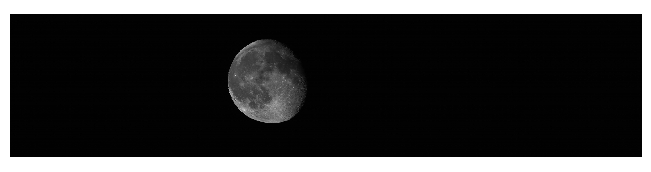

In [6]:
fig=plt.figure(layout='constrained')
plt.axis('off')
plt.imshow(rad, cmap='gray', interpolation='None')

Alright! That's a nice image of the moon! Let's look at a few other files to get a feel for the variety in the dataset:

Quickly, before we go looking at bunch more images, that was a lot of configurations to write out! And if we are going to plot multiple images at once (using subplots) those configuration calls get a lot more complicated really fast. Let's use a settings file so we can avoid that in the rest of the calls we'll make to plot these data. There are a lot of configurations you can set in these files and you can learn more about them [here](https://matplotlib.org/stable/users/explain/customizing.html#customizing-with-style-sheets).

The file in `settings/simple_image.mplstyle` will help us recreate the configuration we set up for the image above for the rest of the data in this file once we call it with `matplotlib.pyplot.style.use`:

In [7]:
plt.style.use('settings/simple_image.mplstyle')

In [8]:
rad1 = Dataset(LUN_FOLDER / 
    'OR_ABI-INST-CAL-LUN-M6C03_G17_s20222801900592_e20222801901048_c20222801901103-t0-s0.nc').variables['radiance']
rad2 = Dataset(LUN_FOLDER / 
    'OR_ABI-INST-CAL-LUN-M6C05_G16_s20221992056556_e20221992057011_c20221992057088-t0-s1.nc').variables['radiance']
rad3 = Dataset(LUN_FOLDER /
    'OR_ABI-INST-CAL-LUN-M6C01_G16_s20223651143552_e20223651144007_c20223651144148-t0-s1.nc').variables['radiance']
rad4 = Dataset(LUN_FOLDER /
    'OR_ABI-INST-CAL-LUN-M6C03_G16_s20231201315549_e20231201316004_c20231201316063-t0-s0.nc').variables['radiance']

And we can plot those all in one plot using subplots.

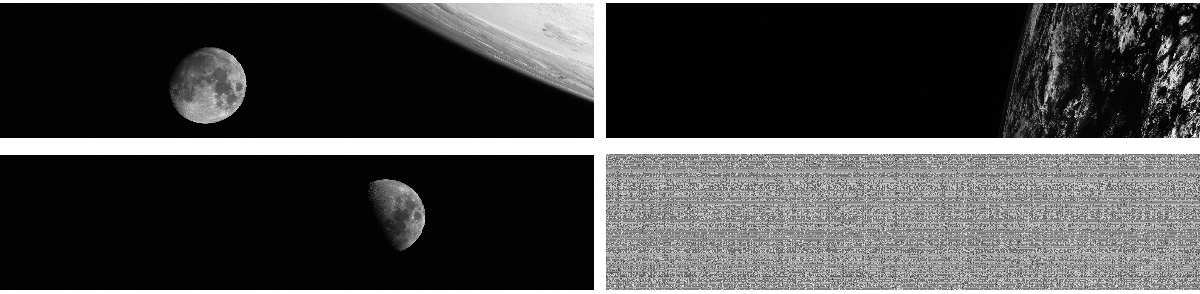

In [22]:
fig = plt.figure(figsize=(12,3))
rad_list = [rad1, rad2, rad3, rad4]
for i in range(1,len(rad_list)+1):
    fig.add_subplot(2,2,i)
    plt.imshow(rad_list[i-1])

Well. It looks like we have more than just simple, nice moon images here. This is going to take some more work to create a clean moon-only dataset to detect phases with!

### Image Processing

## <span style="color:red">TODO: Add more info about general options for image processing library and why you want them</span>

We are going to need to determine which images have the Moon, where it is, and how full it is. To do this we'll use some image processing and computer vision techniques. Before we get started, we should note that you can get a long way in image processing and computer vision with fairly simple operations that are arithmetic-based. These are easier to use then more complex algorithms, but they are also faster to run, easier to inspect, and more reliable than complex algorithms.

It's good to understand low-level techniques if you want to use more complex ones for image recognition or processing, including machine learning methods. Complex techniques often don't work well unless you preprocess your data using simplier functions. Additionally, simple functions can be assembled into quite complex ones.

In this notebook we'll introduce some of these simple techniques and move onto more complex ones in future notebooks.

### Footprint Operations

Many image manipulation techniques rely on looking at each pixel in the image, then applying some kind of mathematical function to the pixels that fall within some region around it. This region is called a "footprint" or "kernel". One of the simplest examples is the _median filter_. It works by replacing each image with the median value of the pixels that fall within a footprint around it. Let's explore its effects:

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import scipy.ndimage as ndi

Here we'll load in an example image of a noisy cross shape. You can find it in the images folder. 

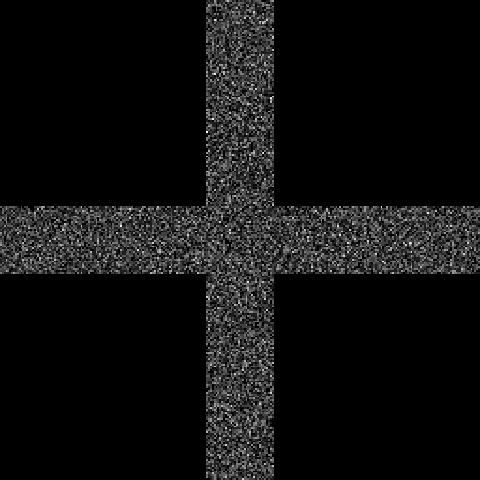

In [11]:
noisecross = np.asarray(Image.open('images/noisecross.png'))
plt.imshow (noisecross)

Now we'll generate big and small footprints for this image by creating numpy arrays of ones of size 10x10 and 3x3 respectively. What is "big" or "small" depends on the size of the image you're applying a filter to!

In [12]:
fbig, fsmall = 10, 3
big_foot, small_foot = np.ones((fbig, fbig)), np.ones((fsmall, fsmall))

print('big_foot: \n', big_foot)
print('small_foot: \n', small_foot)

big_foot: 
 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
small_foot: 
 [[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


We'll apply the median filter here from `scipy.ndImage` and plot them all in plot using subplots again.

The median filter has a "softening" effect. When the footprint is small, the softening is relatively mild; as it gets bigger, the softening gets more intense. This is a little bit like turning up the bass on a piece of music: it emphasizes more consistent parts of the image and suppresses more variable ones.

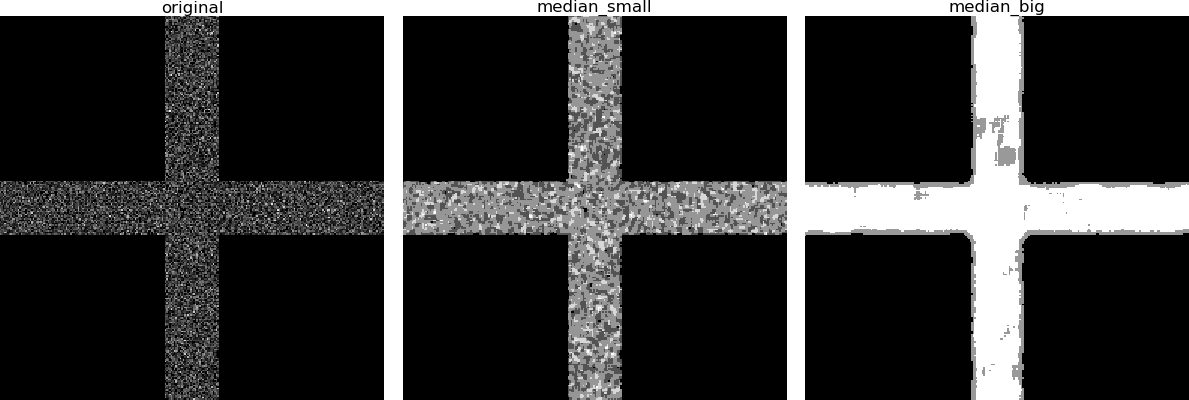

In [81]:
nc_small_median = ndi.median_filter(noisecross, footprint=small_foot)
nc_big_median = ndi.median_filter(noisecross, footprint=big_foot)

fig = plt.figure(figsize=(12,4))
cross_list = [noisecross, nc_small_median, nc_big_median]
titles = ["original", "median_small", "median_big"]
for i in range(1,len(cross_list)+1):
    fig.add_subplot(1,3,i)
    plt.gca().set_title(titles[i-1])
    plt.imshow(cross_list[i-1])

Median filters can be used for many practical purposes. For instance, look at what a median filter can do to the scanlines in this classic Viking Orbiter image (a technique the ground team used to great advantage!):

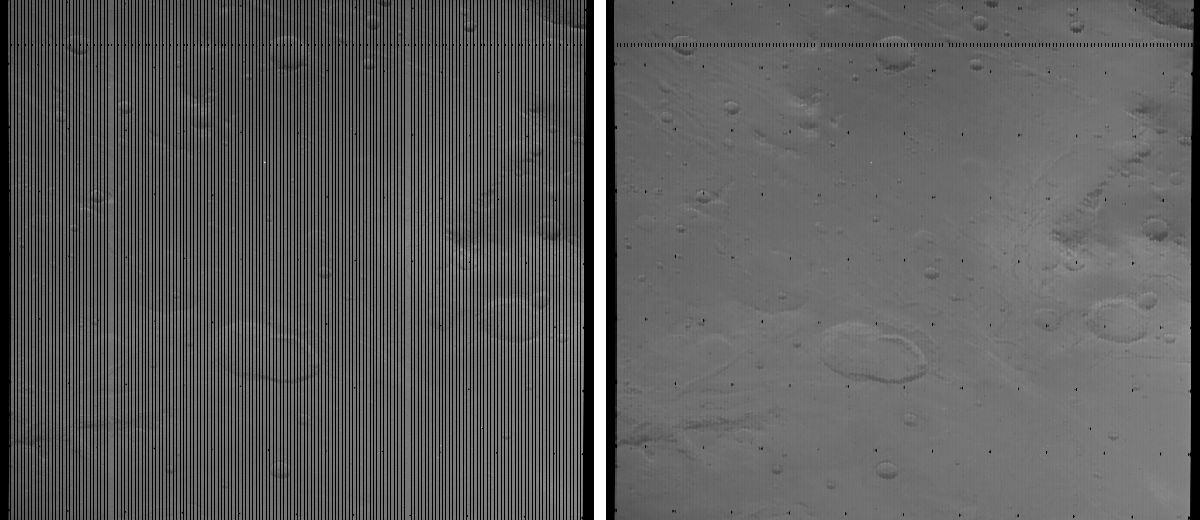

In [20]:
import pdr

viking = pdr.read('images/F611A13.IMG').IMAGE
filtered_viking = ndi.median_filter(viking, footprint=np.ones((4,4)))

fig = plt.figure(figsize=(12,6))

viking_list = [viking, filtered_viking]
for i in range(1,len(viking_list)+1):
    fig.add_subplot(1,2,i)
    plt.imshow(viking_list[i-1])

### Morphological Operators

Morphological operators area type of footprint-based filter that uses logical operations like `and` and `or` instead of arithmetic. Fullness of the Moon is based on shape and line; we should use an operation that works directly with those aspects of images, thus we will use morphological operators 

#### Making Binary Images

Because they do true/false logic, morphological operators want to work on
"binary" images -- black-and-white images made up of only 1s and 0s.

Most images we want to work with don't start out as binary images. The
easiest (and one of the most effective) ways to reduce images to lines
is to set a cutoff value or "threshold". We then set all values below
that threshold to black, and all values above that threshold to white. 
If it's a color image, we also want to turn it to grayscale first.
This often works something like tracing or making an outline of an image --
and these are also good first steps in other processes that want outlines,
like silkscreening.

Let's go ahead and walk through the process.

We'll start by working with this image of a part of a Tiffany lamp:

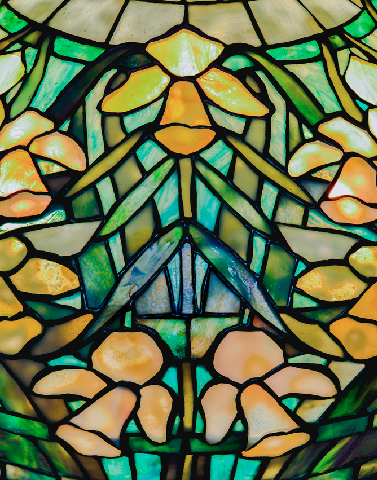

In [24]:
lamp = np.asarray(Image.open("images/tiffany.png"))
plt.imshow(lamp)

Color images are usually 3-D arrays where the third axis represents color channel, in this case red (R), green (G), or blue (B). This would make a purple verison of the image (by setting the second band (index=1) to zero so there is no green in the image):

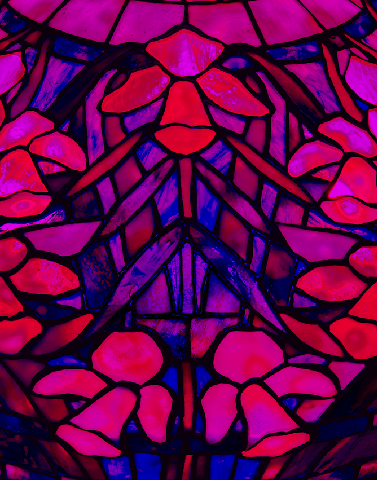

In [26]:
purple_lamp = lamp.copy()
purple_lamp[:,:,1] = 0
plt.imshow(purple_lamp)

The easiest way to make a gray version of a color image is just to merge its channels down, which can be as simple as just taking their mean or median:

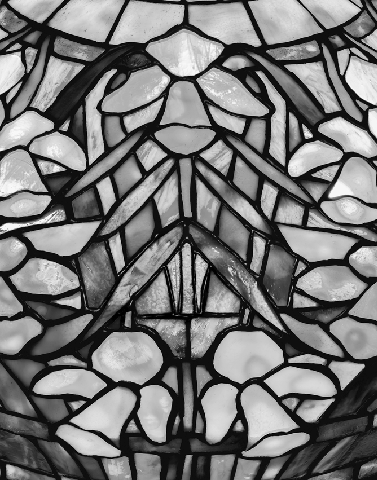

In [27]:
lamp_gray = np.mean(lamp, axis=2)
plt.imshow(lamp_gray)

We can now turn it to a black-and-white binary image with thresholding. Picking the correct threshold value is a little bit of an art and depends on exactly what features you want the outline to retain. Let's see what happens with a few different levels:

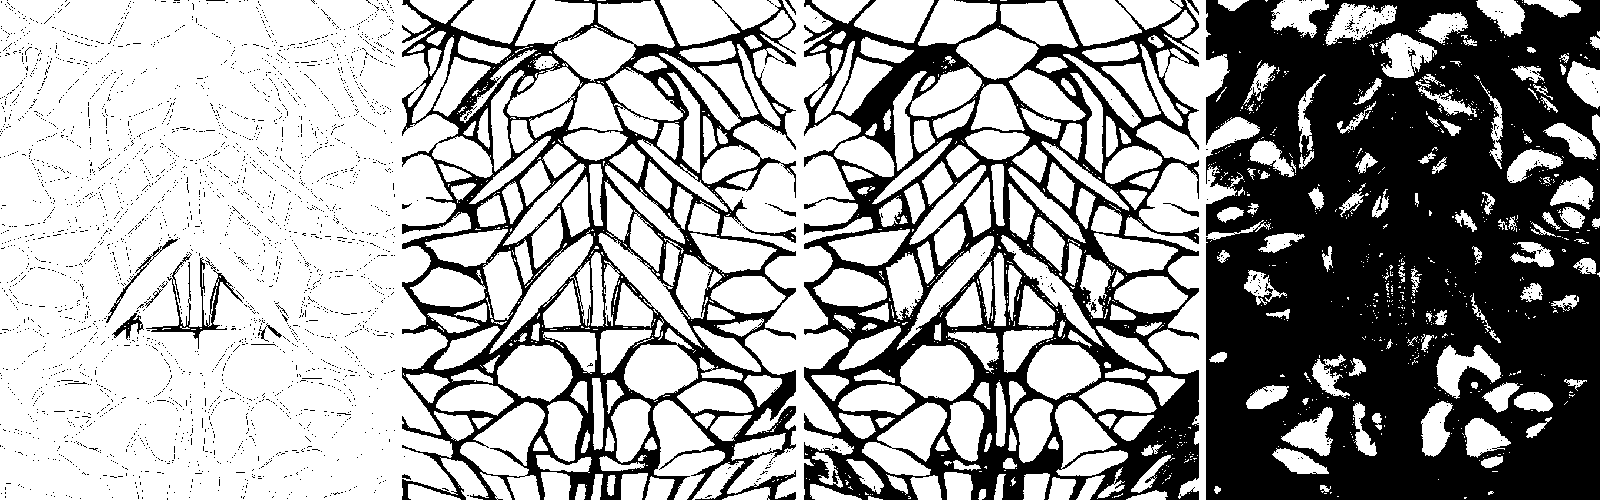

In [47]:
threshold_levels = (10, 25, 50, 160)
outlines = [lamp_gray > level for level in threshold_levels]

fig = plt.figure(figsize=(16,6))

for i in range(1,len(outlines)+1):
    fig.add_subplot(1,4,i)
    plt.imshow(outlines[i-1])

Let's try the second one for our outline -- you might want to try the next steps a few teimse with different settings to see what happens.

In [37]:
lamp_outline = lamp_gray > 25

#### Dilation and Erosion

There are two basic morpholgical operators: erosion and dilation. Most others can be assembled from combinations of these two.

Dilation is an "or". If there is a pixel valued 1 anywhere in the dilation operator's footprint, it sets the center pixel to 1; otherwise it sets it to 0. Erosion is an "and": if _all_ pixels in the erosion operator's footprint are 1, it sets the center pixel to 1; otherwise it sets the center pixel to 0.

This means that erosion will tend to make black parts o the image heavier, thicker, and more coherent, and dilation will do the opposite.

Let's look at erosion and dilation here. Note that, just like the median filter we saw earlier, bigger footprints tend to make morphological operators "stronger" and selecting the correct footprint size or shape for particular images and applications can be a very finicky job.



Because this particular image is basically a black-on-white-outline, erosion will tend to make its lines thicker and its sections more distinct:

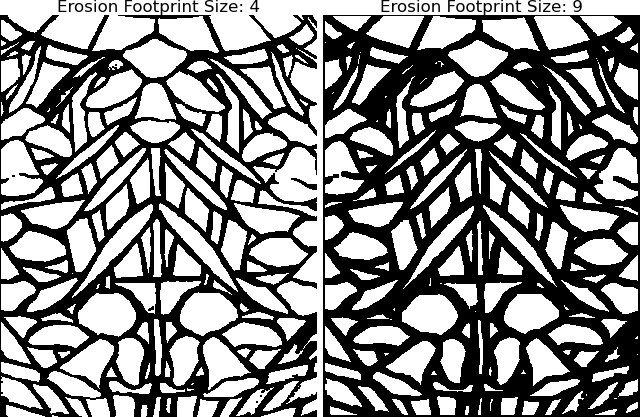

In [45]:
sizes = [4, 9]
eroded = [ndi.binary_erosion(lamp_outline, np.ones((fs, fs))) for fs in sizes]

fig = plt.figure()

for i in range(1,len(eroded)+1):
    fig.add_subplot(1,2,i)
    plt.gca().set_title(f'Erosion Footprint Size: {sizes[i-1]}')
    plt.imshow(eroded[i-1])

Whereas dilation will tend to make its lines tinner and blur sections:

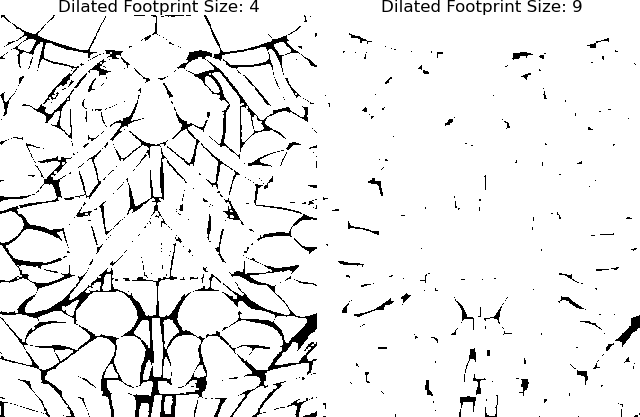

In [48]:
dilated = [ndi.binary_dilation(lamp_outline, np.ones((fs,fs))) for fs in sizes]

fig = plt.figure()

for i in range(1,len(dilated)+1):
    fig.add_subplot(1,2,i)
    plt.gca().set_title(f'Dilated Footprint Size: {sizes[i-1]}')
    plt.imshow(dilated[i-1])

#### Labeling

Being able to manipulate lines like this is very useful in part because it
helps us break images up into meaningful pieces. The simplest way to do this is to
simply find matching regions of the image and assign a unique number to 
them. This process is called "labeling", and many good tools for it exist
in Python.

In the next cell, you'll "thicken" the lamp outline and then use `ndi.label()` 
to assign every connected 1-valued region of that outline its own unique number.
It always assigns 0 to what it identifies as "background". 
You'll see that it doesn't work perfectly -- it may cut some sections at the 
edges off, and can't quite distinguish some regions that might look contiguous to 
your eye because of some junky little line bits that connect them.

Like threshold levels, selecting good footprint sizes and shapes for particular images
and applications can be a very finicky job. If you change the footprint size
from (3, 3) and run the cell again, you will see that you get quite different labels.
If you make it a lot bigger, you'll see that you get _fewer_ labels, because the erosion
will have made image areas more distinct from one another...although if you make it big 
enough, you might not get any at all, because you'll have eroded all the lines into one
big line. You'll also get very different results -- probably _much_ larger and more 
connected labels -- if you swap it to binary dilation.

268 labels found.
<class 'numpy.ndarray'>


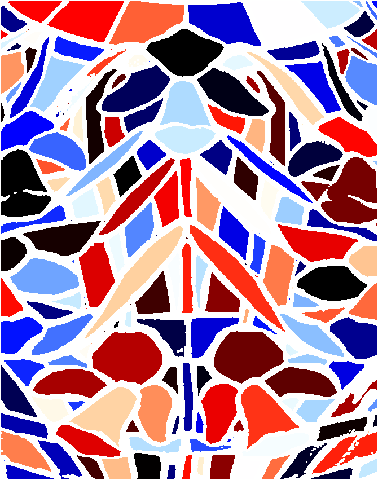

In [55]:
trace = ndi.binary_erosion(lamp_outline, np.ones((3, 3)))
labels, n_labels = ndi.label(trace)
print(f"{n_labels} labels found.")
plt.imshow(np.ma.masked_where(labels == 0, labels), cmap='flag')

We can use this to pick out, count, and locate individual regions of an image. 

In the next cell we'll use the `labels` array we made above, select a few random ones, and plot them so we can drill down into the specific image elements this algorithm identified. You'll note that not every label is interesting -- ndi.label() will happily assign a unique label to a tiny little dot, as long as it's isolated. When we look at our lunar images a little later, we'll need to watch for that.

We could plot just the labels (try adding `plt.imshow(stencil_2d)` at the end of the cell if you'd like to see that). But if we want to see the actual portions of the original image they represent, we'll need to take the two dimensional array of the labels and convert them into a three dimensional stencil to fit on the 3 band color image (`lamp`) that we have. To do this we'll use [`np.tile`](https://numpy.org/doc/stable/reference/generated/numpy.tile.html) to add multiple repititons of the label array (`stencil_2d`) for each band. [`np.tile`](https://numpy.org/doc/stable/reference/generated/numpy.tile.html) will add new axes at the first position of an array so we'll end up with an array of shape (3, 851, 670) but our `lamp` image is (851, 670, 3)! So we'll use [`np.moveaxis`](https://numpy.org/doc/stable/reference/generated/numpy.moveaxis.html) so that the array will be the same shape as the color band image.

The shape of the stencil_2d is: (851, 670)
If we use np.tile to repeat the array its shape would be:(3, 851, 670)
So we'll need to move our first axis to the last position to get the same shape as the lamp image: (851, 670, 3)


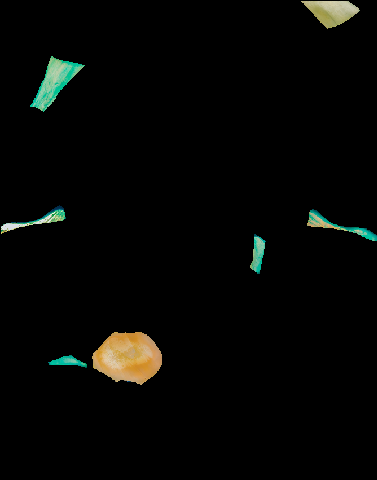

In [87]:
# we aren't including 0 because, remember, that's the label always assigned to the background
random_label_choices = np.random.choice(range(1, n_labels), 8)

stencil_2d = np.isin(labels, random_label_choices)

print(f'The shape of the stencil_2d is: {stencil_2d.shape}')
print(f'If we use np.tile to repeat the array its shape would be:{np.tile(stencil_2d, (3, 1, 1)).shape}')
print(f"So we'll need to move our first axis to the last position to get the same shape as the lamp image: {lamp.shape}")

stencil_3d = np.moveaxis(np.tile(stencil_2d, (3, 1, 1)), 0, 2)

selected_labels = np.where(stencil_3d, lamp, 0)

plt.imshow(selected_labels)

If we want to look at just the background to see what the algorithm pulled out we can do that too:

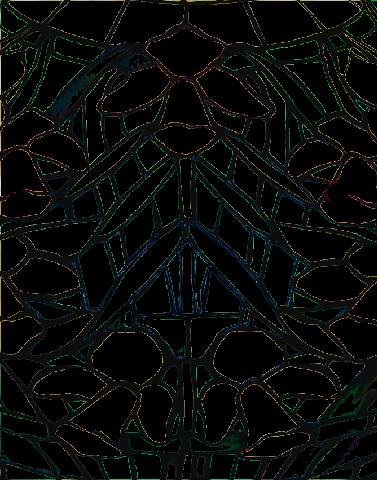

In [73]:
stencil_2d_bkgd = np.isin(labels, 0)
stencil_3d_bkgd = np.moveaxis(np.tile(stencil_2d_bkgd, (3, 1, 1)), 0, 2)
background = np.where(stencil_3d_bkgd, lamp, 0)
plt.imshow(background)

Let's pause for a moment. That was a lot of the same code we just wrote in the last two cells. We're probably going to want to look at more labels when we work with our Moon images. This is the perfect use for a function. Rather than rewriting the same lines over and over we can use a function to cut down on our lines of code. Let's turn what we've just done into a function we can reuse later with our Moon images.

In [75]:
def apply_2d_stencil(color_image, stencil_2d):
    stencil_3d = np.moveaxis(np.tile(stencil_2d, (3, 1, 1)), 0, 2)
    return np.where(stencil_3d, color_image, 0)

def labelstencil(color_image, label_array, label_numbers):
    """
    Return a copy of `color_image` blacked out wherever the values of
    'label_array' don't fall within 'label_numbers'.
    """
    return apply_2d_stencil(color_image, np.isin(label_array, label_numbers))

Using those functions let's rewrite the background cell above:

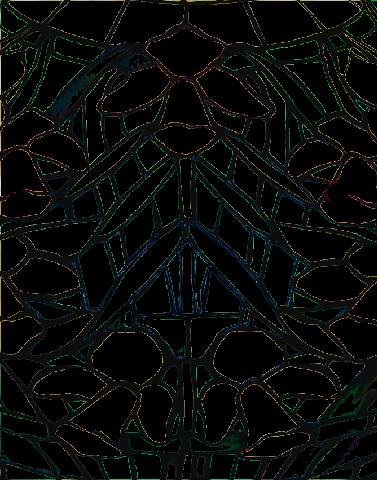

In [77]:
background = labelstencil(lamp, labels, 0)
plt.imshow(background)

That was a lot fewer lines of code and a lot easier to read! Awesome! Functions are great for this.

#### Getting shapes from labels

Because of image defects and the messy imperfection of the world, labels don't usually _exactly_ fit the regions you'd like to find in images, and they also often have very complex boundaries that make some kinds of analysis harder (even when the actual objects in the scene don't). One straightforward technique that's effective in many situations is simply to draw some simple geometric shape like a circle or a rectangle around the label. (Sometimes you're not looking for simple geometric shapes, of course, in which case this would not be a good idea.)

OpenCV has several fast, reliable functions for doing this. Its python wrapper, `cv2`, is very effective, but its expectations are unusual and its error messages aren't always very readable (it's practically like a separate langugage). Rather than spend the rest of this Notebook talking about the OpenCV API, we've provided a couple of example functions in the next cell for performing common tasks of the kind with `cv2`.

In [117]:
cv2.CHAIN_APPROX_SIMPLE

2

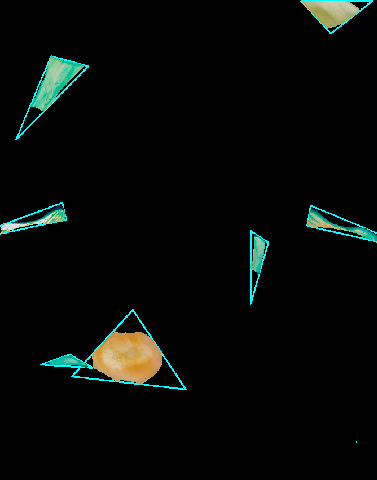

In [108]:
import cv2
random_label_choice = np.random.choice(range(1, n_labels), 8)
assembled = np.zeros_like(lamp)

for label in random_label_choices:
    mask = np.isin(labels, label)
    canvas = np.zeros([*mask.shape, 3], 'u1')
    (cont,), _ = cv2.findContours(mask.astype('u1'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    param = {}
    param['area'], param['points'] = cv2.minEnclosingTriangle(cont)
    drawn = cv2.drawContours(canvas, [param['points'].round().astype('i4')], 0, (0, 255, 255), 2)
    assembled +=drawn
plt.imshow(np.clip(assembled + labelstencil(lamp, labels, random_label_choices), 0, 255))


In [115]:
import cv2
random_label_choice = np.random.choice(range(1, n_labels), 8)
assembled = np.zeros_like(lamp)

mask = np.isin(labels, [3, 42])
len(cv2.findContours(mask.astype('u1'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0])



2

## insert stuff from morphology_snippet

### **TODO: write other pipeline handler (shoult be very simple)**

# getting ground truth
## (this can potentially be replaced by providing an index file)

In [ ]:
def get_time_metadata():
    """
    Extract time metadata from the NetCDF files so that we can get the 
    'offical' percent illumination of the Moon at each of those times
    from JPL using LHorizon.
    """
    return [
        {'name': f.name, 'utc': Dataset(f).time_coverage_start}    
        for f in [f for f in LUN_FOLDER.iterdir() if f.suffix == ".nc"]
    ]

In [ ]:
file_index = pd.DataFrame(get_time_metadata())
# The NetCDF files contain these time codes as strings.
# Convert them to datetime64 for more convenient calculations.
file_index['utc'] = pd.to_datetime(file_index['utc'])
# And let's go ahead and sort it by time, too:
file_index = file_index.sort_values(by='utc').reset_index(drop=True)

In [ ]:
# Add a Julian day column to the time index to make it more
# convenient to request ephemeris data (it'll be shorter, so we can
# make requests to the API more easily). We'll again make use of the
# extremely convenient time conversion functions from astropy.time.
import astropy.time as at  

# [maybe, if we haven't: explain Julian day scale]
# Let's also round it to two decimal places to further reduce the 
# number of API calls we need to make -- we definitely don't need 
# more than hundredth-of-a-day resolution for this application 
# (about 14.4 minutes).
file_index['jd'] = at.Time(file_index['utc']).jd.round(2)

In [ ]:
# Now we put them all together and reset the index.
illumination_df = pd.concat(illumination_chunks).reset_index(drop=True)

In [ ]:
# Horizons offers lots of different quantities. We want, specifically,
# illuminated fraction. Let's look up that number in lhorizon's index.
import re
from lhorizon.constants import HORIZONS_QUANTITY_NAMES

# 'OBSERVER' refers to the JPL Horizons mode. OBSERVER is the default.
[
    (k, v) for k, v in HORIZONS_QUANTITY_NAMES['OBSERVER'].items() 
    if re.search('illuminated', v, re.I)
]

In [ ]:
# Target-Observer-Moon angle won't be very useful because we're measuring this 
# from Earth to the Moon, so we'll just pick 10.
from lhorizon import LHorizon

# If we try to do all the times at once, JPL Horizons will get upset.
# We'll chunk them into groups of 100, which should be safe.
# This kind of chunked or "paginated" operation is very useful with
# many networked resources.
chunksize, illumination_chunks = 100, []
chunk_starts = tuple(range(0, len(file_index), chunksize))
for start_ix in chunk_starts:
    timechunk = file_index['jd'].iloc[start_ix:start_ix + chunksize]
    query = LHorizon(
        origin=399,  # JPL's code for the Earth
        target=301,  # JPL's code for the Moon
        quantities=(10,),
        epochs=timechunk
    )
    # We only really care about 'ill' (illuminated fraction), but 
    # we'll check the 'jd' column as well to make sure it matches what
    # we sent -- just to make sure we didn't get anything out of order.
    illumination_chunks.append(query.table()[['ill', 'jd']])
    print(f"fetched {timechunk.index[-1] + 1} of {len(file_index)}")

In [ ]:
# The rows of this dataframe should correspond exactly to the rows of
# file_index. Let's see if they do:
assert (file_index['jd'] == illumination_df['jd']).all(), "Sorting problem!"
print("The query sorted itself correctly.")

In [ ]:
# Now we can lose that redundant 'jd' column and just put the % illumination
# information on our file index.
file_index = pd.concat([file_index, illumination_df['ill']], axis=1)

In [ ]:
# NOTE: I'm writing this out for at least our dev convenience, and we can
# also just provide exactly this file.
Path("indices").mkdir(exist_ok=True)
file_index.to_csv("indices/lun_index.csv", index=None)

In [ ]:
# Let's make a couple quick plot of the %illumination across the dataset, just to see
# what we've got.

import matplotlib.pyplot as plt
%matplotlib qt

# This first plot is a simple time-vs.-illumination graph:
plt.scatter(file_index['utc'], file_index['ill'], linewidth=2)

In [ ]:
# Hmm. That's not the most revealing graph in the world. There are a lot of 
# gaps in it, because the GOES satellites don't _constantly_ take pictures of 
# the Moon. Let's take a look at a histogram instead, so we have an idea of 
# what Moon phases we can expect to find most often -- or at all -- in our 
# dataset. (This is often a good technique for exploring a new dataset -- 
# it's harder to work with data if you don't know what data you have).
# You'll note that we have only a couple of potential images of the Moon 
# below half full, but a good selection between half full and full.

# plt.close('all')
_ = plt.hist(file_index['ill'], bins=32)

In [ ]:
# Check simple linear correlation between our computed ratios and
# ephemeris-derived illumination percentage. With the right parameters,
# you can get a linear correlation over 0.95...
from scipy.stats import linregress

# This is a simple linear regression function that returns a tuple
# giving slope, intercept, rvalue (strength of correlation), 
# pvalue (significance of correlation), and errors.
regression = linregress(valid_results['ratio'], valid_results['ill'])
regression.rvalue, regression.pvalue

In [ ]:
valid_results['ill']

In [ ]:
# Plot the regression.

# Make an x axis for the line...
x_axis = np.linspace(
    valid_results['ratio'].min(), 
    valid_results['ratio'].max(), 
    len(valid_results)
)
# Then it's just y = mx + b.
line = x_axis * regression.slope + regression.intercept
plt.plot(x_axis, line, linewidth=3, color='r')
plt.scatter(valid_results['ratio'], valid_results['ill'], c='k')

In [ ]:
# Even if you have a strong correlation, you'll probably have at least a few 
# extreme outliers.
# If you want to further tweak parameters -- or find out why this
# algorithm simply might not be able to work on a particular image at all --
# go ahead and look at them individually:

# offset from best linear fit
relative_offset = abs( 
    1 - valid_results['ill'] 
    / (valid_results['ratio'] * regression.slope + regression.intercept)
)
# Now what are our 98th-percentile outliers...
outliers = valid_results.loc[
    relative_offset > np.percentile(relative_offset, 98)
]

In [ ]:
# Let's go ahead and look at one. Perhaps you can figure out why it 
# didn't work!
outlier = outliers.sample().iloc[0]
rad = Dataset(LUN_FOLDER / outlier['name']).variables['radiance'][:]
plt.imshow(rad, cmap='Greys_r')

In [ ]:
# Similarly, it might also be good to look at images the algorithm 
# didn't find a Moon in at all. Were those correct or incorrect
# nondetections?
invalid = pipeline_results.loc[pipeline_results['error'].notna()]
badrow = invalid.sample().iloc[0]
badrad = Dataset(LUN_FOLDER / badrow['name']).variables['radiance'][:]
plt.imshow(badrad, cmap='Greys_r')

# Qualitative examination of Moon images
----
## section placeholder